##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a CNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

2022-08-08 11:54:34.744506: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

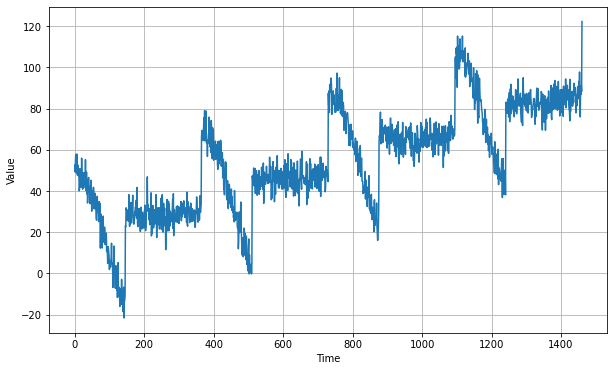

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

2022-08-08 11:55:26.567251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 11:55:26.580951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 11:55:26.581332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-08 11:55:26.582937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/100


/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-08-08 11:55:33.681269: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-08 11:55:34.832375: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 148.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-08 11:55:34.832453: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 148.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-08 11:55:34.849471: E tensorflow/stream_

NotFoundError: Graph execution error:

Detected at node 'sequential/conv1d/Conv1D' defined at (most recent call last):
    File "/home/ubuntu/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/ubuntu/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/ubuntu/anaconda3/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/home/ubuntu/anaconda3/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/home/ubuntu/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_6283/3967655284.py", line 25, in <module>
      history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/ubuntu/anaconda3/lib/python3.9/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'sequential/conv1d/Conv1D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4023): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4023): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4023): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4023): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4023): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4023): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 155189888 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 155189888 bytes.
  Profiling failure on CUDNN engine 5#TC: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4023): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 5: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4023): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
	 [[{{node sequential/conv1d/Conv1D}}]] [Op:__inference_train_function_5626]

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

## Fully Convolutional Forecasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

In [ ]:
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()